# Setup and Load Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning models and tools
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance

# Evaluation metrics and visualization
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
)
from sklearn.calibration import calibration_curve

# Hyperparameter optimization
import optuna

# Load Economic Data
This is freely downloadable from: https://www.philadelphiafed.org/surveys-and-data/regional-economic-analysis/state-coincident-indexes

In [2]:
# Load state-level economic data
econ = pd.read_csv("State_Level_Economy.csv")

# Convert 'Date' column to datetime (format like "Jan-80")
econ["Date"] = pd.to_datetime(econ["Date"], format="%b-%y")
econ["Year"] = econ["Date"].dt.year
econ["Month"] = econ["Date"].dt.month

# Filter: election years only (1980–2020), months Jan–June
econ = econ[(econ["Year"].isin(range(1980, 2021, 4))) & (econ["Month"] <= 6)]

# Reshape to long format
econ_long = econ.melt(id_vars=["Date", "Year", "Month"], var_name="State", value_name="Index")
econ_long = econ_long.dropna(subset=["Index"])

**Calculate Weighted Growth (Jan–June):**  
This uses linearly increasing weights:  
e.g.,  
for January:  
1 / (1 + 2 + 3 + 4 + 5 + 6)  
for February:  
2 / (1 + 2 + 3 + 4 + 5 + 6)


In [3]:
# Linear weights for Jan–June
weights = pd.DataFrame({
    "Month": range(1, 7),
    "Weight": [m / sum(range(1, 7)) for m in range(1, 7)]
})

# Merge weights and calculate lag + percent change
econ_weighted = econ_long.merge(weights, on="Month")
econ_weighted = econ_weighted.sort_values(["State", "Year", "Month"])
econ_weighted["Lag_Index"] = econ_weighted.groupby(["State", "Year"])["Index"].shift(1)
econ_weighted.dropna(subset=["Lag_Index"], inplace=True)
econ_weighted["Pct_Change"] = (econ_weighted["Index"] - econ_weighted["Lag_Index"]) / econ_weighted["Lag_Index"]

# Summarise weighted growth by state-year
state_growth = (
    econ_weighted
    .groupby(["State", "Year"])[["Pct_Change", "Weight"]]
    .apply(lambda df: np.sum(df["Pct_Change"] * df["Weight"]))
    .reset_index(name="weighted_growth")
)


**Impute Missing Data for DC**

This uses a simple average of the nation-wide ("US") and two similar states: New York and Massachusetts 

In [4]:
# Compute average weighted growth for DC from US, NY, MA
ref_growth = state_growth[state_growth["State"].isin(["US", "NY", "MA"])]
dc_growth = ref_growth.groupby("Year")["weighted_growth"].mean().reset_index()
dc_growth["State"] = "DC"

# Append DC to main state_growth dataset
state_growth = pd.concat([state_growth, dc_growth], ignore_index=True)

# state_growth.head()

# Load Approval Ratings Data
This is also freely avaliable at: https://ropercenter.cornell.edu/ipoll/study?doi=10.25940/ROPER-31120311
(Note: a lisence is required.)

In [5]:
# Load the data
approval = pd.read_csv("31120311.csv")

# Filter out missing values in pres_approve2
approval_filtered = approval[approval["pres_approve2"] != -99].copy()

# Extract numeric approval value (0 or 1)
approval_filtered["pres_approve2_num"] = (
    approval_filtered["pres_approve2"]
    .astype(str)
    .str.extract(r"^(\d)")
    .astype(float)
)

# Drop rows where data processing failed
approval_filtered = approval_filtered[approval_filtered["pres_approve2_num"].notna()]

# Group by and calculate approval stats
net_approval_by_state_year = (
    approval_filtered
    .groupby(["year", "state_num", "state_initial", "state_name"])
    .agg(
        approve_rate=("pres_approve2_num", "mean"),
        n=("pres_approve2_num", "count")
    )
    .reset_index()
)

# Calculate approval, disapproval, and net approval ratings 
net_approval_by_state_year["disapprove_rate"] = 1 - net_approval_by_state_year["approve_rate"]
net_approval_by_state_year["net_approval"] = (
    net_approval_by_state_year["approve_rate"] - net_approval_by_state_year["disapprove_rate"]
)

# Rename columns for clarity and consistency
approval_clean = net_approval_by_state_year.rename(columns={
    "state_initial": "State",
    "year": "Year"
})

Looking at the approval data, we see that some states-years have very few (some only 1!) observations

In [6]:
# Define presidential election years from 1980 to 2020
election_years = list(range(1980, 2021, 4))

# Filter data for those years
election_year_data = approval_clean[approval_clean["Year"].isin(election_years)]

# Summary statistics for sample size 'n' by year
summary_stats = (
    election_year_data
    .groupby("Year")["n"]
    .describe()
    .round(2)
)

# Display the summary stats
print("\nSummary statistics for sample size (n) by election year:")
print(summary_stats)



Summary statistics for sample size (n) by election year:
      count    mean     std   min     25%    50%     75%     max
Year                                                            
1980   50.0  393.44  430.41   4.0   67.25  244.0  578.25  1867.0
1984   51.0  381.49  410.32   4.0  105.50  236.0  465.50  2164.0
1988   49.0  307.96  283.41  13.0   97.00  244.0  403.00  1325.0
1992   49.0  549.96  506.01  54.0  179.00  398.0  696.00  2403.0
1996   51.0  334.41  342.31  10.0   89.00  240.0  428.50  1721.0
2000   51.0  380.71  375.98   4.0  134.00  285.0  471.00  1996.0
2004   51.0  375.18  368.61   1.0  124.50  269.0  468.50  1914.0
2008   51.0  334.04  319.31   3.0  111.50  244.0  409.50  1681.0
2012   51.0  379.75  340.68  29.0  138.00  293.0  476.50  1693.0
2016   51.0  386.71  395.84  32.0  129.50  278.0  470.00  2014.0
2020   51.0  213.00  221.12  21.0   75.50  144.0  259.00  1180.0


# Load Election Data
This is also freely avaliable at: https://dataverse.harvard.edu/citation?persistentId=doi:10.7910/DVN/42MVDX

In [24]:
# Load the raw presidential election data
raw_elections_df = pd.read_csv("1976-2020-president.csv")

# Standardize capitalization for consistency
raw_elections_df["state"] = raw_elections_df["state"].str.title()
raw_elections_df["party_simplified"] = raw_elections_df["party_simplified"].str.title()

# Identify the top vote-getter per state-year
raw_elections_df["top_votes"] = (
    raw_elections_df.groupby(["year", "state_po"])["candidatevotes"].transform("max")
)

# Create a flag for whether the Democrat won that state-year
raw_elections_df["Dem_Won"] = (
    (raw_elections_df["party_simplified"] == "Democrat") &
    (raw_elections_df["candidatevotes"] == raw_elections_df["top_votes"])
).astype(int)

# Aggregate to one row per state-year:
# - Total Democratic votes
# - Total votes cast
# - Whether Democrat won
elections_1976_2020_final = (
    raw_elections_df.groupby(["year", "state_po", "state"], as_index=False)
    .agg(
        DemVotes=("candidatevotes", lambda x: x[raw_elections_df.loc[x.index, "party_simplified"] == "Democrat"].sum()),
        TotalVotes=("totalvotes", "first"),
        Dem_Won=("Dem_Won", "max")
    )
)

# Rename columns for clarity
elections_1976_2020_final.rename(columns={
    "year": "Year",
    "state_po": "State",        # Abbreviation (e.g., CA)
    "state": "State_Name"       # Full name (e.g., California)
}, inplace=True)

# Final preview
elections_1976_2020_final.head()


,Year,State,State_Name,DemVotes,TotalVotes,Dem_Won
0,1976,AK,Alaska,44058,123574,0
1,1976,AL,Alabama,659170,1182850,1
2,1976,AR,Arkansas,498604,767535,1
3,1976,AZ,Arizona,295602,742719,0
4,1976,CA,California,3742284,7803770,0


**Additional Data Wrangling**

Here, I get the additional political variables, in particular: 
1. Lagged Democratic Overperformance in each State (state vs nation-wide Democratic share in last election)
2. Party in Power (used for interaction terms)
3. Incumbency Penalty: if *any* party has held power for 2 consecutive terms 

In [8]:
# Compute Dem Party Share
elections_1976_2020_final["Dem_Party_Share"] = (
    elections_1976_2020_final["DemVotes"] / elections_1976_2020_final["TotalVotes"]
)

# Sort and compute state-level lagged vote share
dem_share_data = elections_1976_2020_final.sort_values(by=["State", "Year"]).copy()

dem_share_data["State_Dem_Share_4yr_ago"] = (
    dem_share_data.groupby("State")["Dem_Party_Share"].shift(1)
)

# Compute national vote shares and lags
national_share = (
    dem_share_data
    .groupby("Year", as_index=False)
    .agg(
        National_Dem_Share=("DemVotes", "sum"),
        National_Total=("TotalVotes", "sum")
    )
)
national_share["National_Dem_Share"] = (
    national_share["National_Dem_Share"] / national_share["National_Total"]
)

# Compute lagged national shares
national_share["National_Dem_Share_4yr_ago"] = national_share["National_Dem_Share"].shift(1)
national_share = national_share.drop(columns=["National_Total"])

# Merge back into main dataset
dem_share_data = pd.merge(dem_share_data, national_share, on="Year", how="left")

# Compute state deviations
dem_share_data["State_Deviation_4yr"] = (
    dem_share_data["State_Dem_Share_4yr_ago"] - dem_share_data["National_Dem_Share_4yr_ago"]
)

# Define party in power manually (1 = Democrats
party_in_power = {
    1976: -1, 1980: 1, 1984: -1, 1988: -1,
    1992: -1, 1996: 1, 2000: 1, 2004: -1,
    2008: -1, 2012: 1, 2016: 1, 2020: -1
}

def get_party(year):
    return party_in_power.get(year, np.nan)

def get_penalty(year):
    try:
        prev_party = party_in_power[year - 4]
        two_back_party = party_in_power[year - 8]
        if  prev_party == two_back_party:
            return 1
    except KeyError:
        return 0
    return 0

# Apply to the DataFrame
dem_share_data["current_president"] = dem_share_data["Year"].apply(get_party)
dem_share_data["incumbency_penalty"] = dem_share_data["Year"].apply(get_penalty)

# dem_share_data.head()
# Show rows where penalty was applied
print(dem_share_data.loc[dem_share_data["incumbency_penalty"] == 1, ["Year", "current_president"]].drop_duplicates())

    Year  current_president
4   1992                 -1
5   1996                  1
7   2004                 -1
9   2012                  1
11  2020                 -1


# Merging all 3 Datasets (Economic, Approval, Election Results)


In [9]:
merged_all = (
    dem_share_data
    .merge(
        state_growth[["State", "Year", "weighted_growth"]],
        on=["State", "Year"],
        how="left"
    )
    .merge(
        approval_clean[["State", "Year", "net_approval"]],
        on=["State", "Year"],
        how="left"
    )
)
print(merged_all.head())

   Year State State_Name  DemVotes  TotalVotes  Dem_Won  Dem_Party_Share  \
0  1976    AK     Alaska     44058      123574        0         0.356531   
1  1980    AK     Alaska     41842      158445        0         0.264079   
2  1984    AK     Alaska     62007      207605        0         0.298678   
3  1988    AK     Alaska     72584      200116        0         0.362710   
4  1992    AK     Alaska     78294      258506        0         0.302871   

   State_Dem_Share_4yr_ago  National_Dem_Share  National_Dem_Share_4yr_ago  \
0                      NaN            0.498527                         NaN   
1                 0.356531            0.410199                    0.498527   
2                 0.264079            0.404186                    0.410199   
3                 0.298678            0.455488                    0.404186   
4                 0.362710            0.428842                    0.455488   

   State_Deviation_4yr  current_president  incumbency_penalty  \
0        

In [10]:
# Optional: Stats
print(merged_all["net_approval"].describe())
print(merged_all.isna().sum())


count    602.000000
mean       0.005105
std        0.254555
min       -1.000000
25%       -0.157192
50%        0.018537
75%        0.175499
max        0.800000
Name: net_approval, dtype: float64
Year                           0
State                          0
State_Name                     0
DemVotes                       0
TotalVotes                     0
Dem_Won                        0
Dem_Party_Share                0
State_Dem_Share_4yr_ago       51
National_Dem_Share             0
National_Dem_Share_4yr_ago    51
State_Deviation_4yr           51
current_president              0
incumbency_penalty             0
weighted_growth               51
net_approval                  10
dtype: int64


**Imputating missing values for Net Approval**

We see there are missing values for Net Approval. (THe missing values for election results come from pre 1976 elections – which we don't end up using). 

I define this in a functional way, such that the code could be re-used if there are *other* variables with missing data in the future.

In [11]:
# Make a copy to preserve the original data
imputed_data = merged_all.copy()

# Define variables to impute
variables_to_impute = ["net_approval"]

# Get unique states
states = imputed_data["State"].unique()

# Begin imputation loop for each variable
for var in variables_to_impute:
    for state_i in states:
        # Filter to current state's data
        state_data = imputed_data[imputed_data["State"] == state_i]

        # Skip if no missing values
        if not state_data[var].isna().any():
            continue

        # State-specific average (excluding missing)
        Xbar_i = state_data[var].mean(skipna=True)

        # Identify years with missing values
        missing_years = state_data[state_data[var].isna()]["Year"]

        for t in missing_years:
            # Use Training data from this state with observed values
            training_data = (
                imputed_data[(imputed_data["State"] == state_i) & (~imputed_data[var].isna())]
                [["Year", var]]
                .rename(columns={var: "X_state"})
            )

            # Other states' average values for the same years
            other_states_data = (
                imputed_data[
                    (imputed_data["State"] != state_i) &
                    (imputed_data["Year"].isin(training_data["Year"])) &
                    (~imputed_data[var].isna())
                ]
                .groupby("Year")[var]
                .mean()
                .reset_index()
                .rename(columns={var: "X_other_avg"})
            )

            # Merge training inputs
            training_combined = pd.merge(training_data, other_states_data, on="Year")
            training_combined["Xbar_i"] = Xbar_i
            training_combined.dropna(inplace=True)

            # Fit model if sufficient data
            if len(training_combined) >= 2:
                X = sm.add_constant(training_combined[["Xbar_i", "X_other_avg"]])
                y = training_combined["X_state"]
                model = sm.OLS(y, X).fit()

                # Prepare input for prediction
                pred_other_avg = (
                    imputed_data[
                        (imputed_data["State"] != state_i) &
                        (imputed_data["Year"] == t) &
                        (~imputed_data[var].isna())
                    ][var].mean()
                )

                if np.isnan(pred_other_avg):
                    continue  # Skip if other states don't have data for this year

                X_new = pd.DataFrame({
                    "Xbar_i": [Xbar_i],
                    "X_other_avg": [pred_other_avg]
                })
                X_new = sm.add_constant(X_new)

                # Predict and Impute
                predicted_value = model.predict(X_new)[0]
                imputed_data.loc[
                    (imputed_data["State"] == state_i) & (imputed_data["Year"] == t),
                    var
                ] = predicted_value

# Filter to years >= 1980
analysis_dataset = imputed_data[imputed_data["Year"] >= 1980]

# Check for missing values after filtering
print("\n Missing values in the dataset (Year >= 1980):")
print(analysis_dataset.isna().sum())




 Missing values in the dataset (Year >= 1980):
Year                          0
State                         0
State_Name                    0
DemVotes                      0
TotalVotes                    0
Dem_Won                       0
Dem_Party_Share               0
State_Dem_Share_4yr_ago       0
National_Dem_Share            0
National_Dem_Share_4yr_ago    0
State_Deviation_4yr           0
current_president             0
incumbency_penalty            0
weighted_growth               0
net_approval                  0
dtype: int64


# Exploratory Analaysis 

First, I run a simple linear model using all the data.

In [12]:
# Copy and feature engineer the data
merged_filtered = analysis_dataset.copy()

# Create interaction terms and binary party indicator
merged_filtered["party_factor"] = merged_filtered["current_president"].map({1: "Democrat", -1: "Republican"})
merged_filtered["is_republican"] = (merged_filtered["party_factor"] == "Republican").astype(int)

# Interaction terms
merged_filtered["weighted_growth_x_party"] = merged_filtered["weighted_growth"] * merged_filtered["is_republican"]
merged_filtered["net_approval_x_party"] = merged_filtered["net_approval"] * merged_filtered["is_republican"]
merged_filtered["incumbency_penalty_x_party"] = merged_filtered["incumbency_penalty"] * merged_filtered["is_republican"]

# Run the linear model with state fixed effects
model3 = smf.ols(
    formula="""
        Dem_Won ~ C(State) +
                  weighted_growth + 
                  net_approval + 
                  weighted_growth_x_party + 
                  net_approval_x_party + 
                  incumbency_penalty + 
                  incumbency_penalty_x_party +
                  State_Deviation_4yr
    """,
    data=merged_filtered
).fit(
    cov_type='cluster',
    cov_kwds={'groups': merged_filtered['State']}
)

# Show summary
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:                Dem_Won   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     80.26
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           5.84e-25
Time:                        16:50:06   Log-Likelihood:                -86.485
No. Observations:                 561   AIC:                             289.0
Df Residuals:                     503   BIC:                             540.1
Df Model:                          57                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 7
  warnings.warn('covariance of constraints does not have full '


**Exploring Multicollinearity**

Next, I calcualte VIFs (for continuous variables) 

Proportion of Dem_Won:
 Dem_Won
0    0.590018
1    0.409982
Name: proportion, dtype: float64


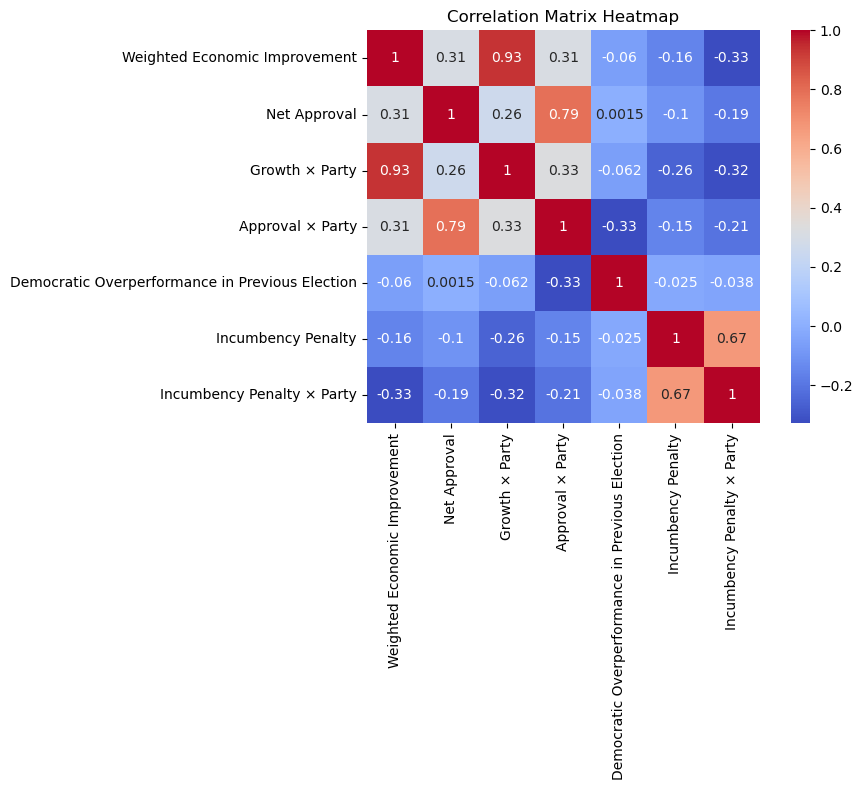

/var/folders/fg/05syns6110s2k8rfgq4d7m6c0000gn/T/ipykernel_9222/1063093115.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_plot_data["Pretty"] = vif_plot_data["Feature"].map(pretty_labels)
/var/folders/fg/05syns6110s2k8rfgq4d7m6c0000gn/T/ipykernel_9222/1063093115.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_plot_data, x="VIF", y="Pretty", palette="viridis")


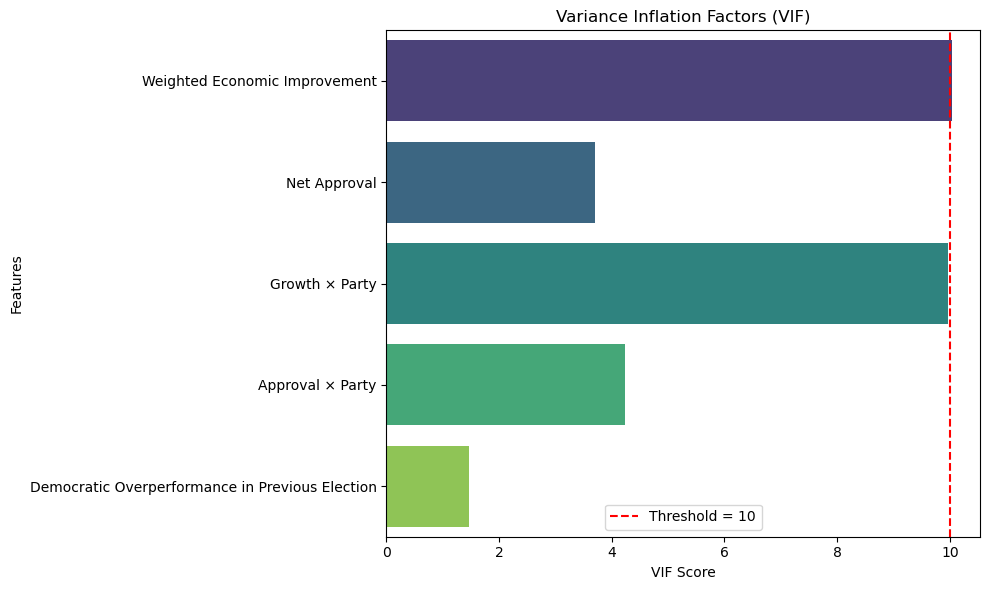

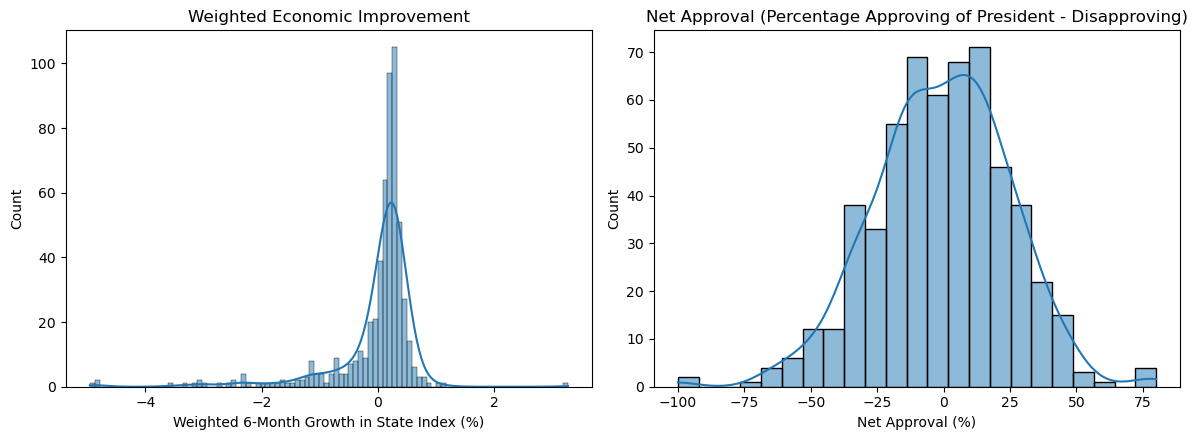

/var/folders/fg/05syns6110s2k8rfgq4d7m6c0000gn/T/ipykernel_9222/1063093115.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_filtered, x=col, palette="Set2", ax=ax)
/var/folders/fg/05syns6110s2k8rfgq4d7m6c0000gn/T/ipykernel_9222/1063093115.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Penalty", "Incumbency Penalty"])


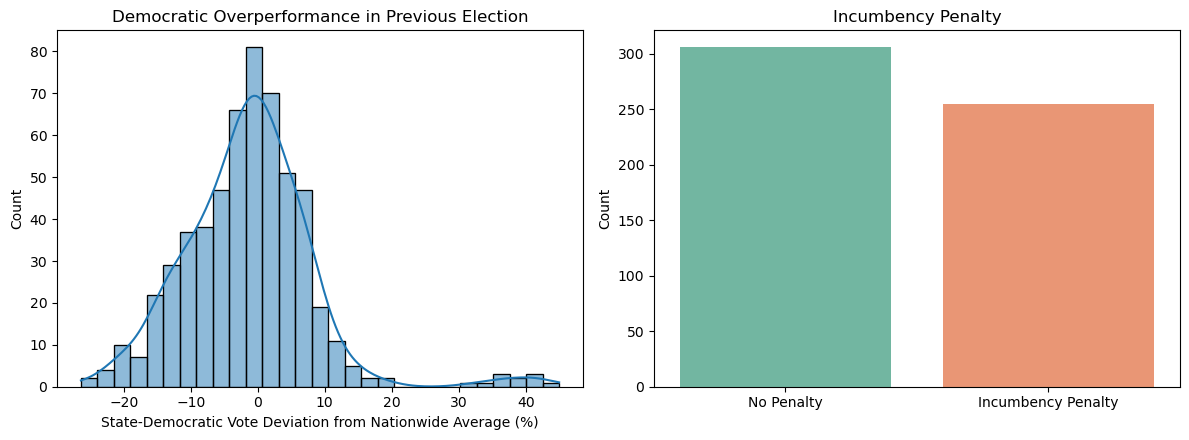

In [13]:
# Class imbalance on outcome variable
print("Proportion of Dem_Won:\n", merged_filtered["Dem_Won"].value_counts(normalize=True))

# Defining all variables for Correlation Matrix
all_vars = [
    "weighted_growth",
    "net_approval",
    "weighted_growth_x_party",
    "net_approval_x_party",
    "State_Deviation_4yr", 
    "incumbency_penalty",
    "incumbency_penalty_x_party"
]

# Pretty labels for plotting
pretty_labels = {
    "weighted_growth": "Weighted Economic Improvement",
    "net_approval": "Net Approval",
    "weighted_growth_x_party": "Growth × Party",
    "net_approval_x_party": "Approval × Party",
    "State_Deviation_4yr": "Democratic Overperformance in Previous Election",
    "incumbency_penalty": "Incumbency Penalty",
    "incumbency_penalty_x_party": "Incumbency Penalty × Party"
}


# PLOT 1: CORRELATION MATRIX

corr_matrix = merged_filtered[all_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True,
            xticklabels=[pretty_labels[c] for c in all_vars],
            yticklabels=[pretty_labels[c] for c in all_vars])
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# VIF Calculation
X = merged_filtered[all_vars]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data["Feature"] != "const"]

# Filter VIF plot to exclude 'incumbency_penalty'
vif_plot_data = vif_data[~vif_data["Feature"].isin(["incumbency_penalty", "incumbency_penalty_x_party"])]
vif_plot_data["Pretty"] = vif_plot_data["Feature"].map(pretty_labels)


## PLOT 2: VIF

# VIF Barplot (excluding 'incumbency_penalty')
plt.figure(figsize=(10, 6))
sns.barplot(data=vif_plot_data, x="VIF", y="Pretty", palette="viridis")
plt.title("Variance Inflation Factors (VIF)")
plt.xlabel("VIF Score")
plt.ylabel("Features")
plt.axvline(10, linestyle='--', color='red', label='Threshold = 10')
plt.legend()
plt.tight_layout()
plt.show()



# PLOT 3: DISTRIBUTION OF CONTINUOUS VARIABLES

import matplotlib.pyplot as plt
import seaborn as sns

# Define variables and plot settings – we want variables expressed as percentages (x 100)
variables_of_interest = {
    "weighted_growth": {
        "title": "Weighted Economic Improvement",
        "xlabel": "Weighted 6-Month Growth in State Index (%)",
        "transform": lambda x: x * 100,
    },
    "net_approval": {
        "title": "Net Approval (Percentage Approving of President - Disapproving)",
        "xlabel": "Net Approval (%)",
        "transform": lambda x: x * 100,
    },
    "State_Deviation_4yr": {
        "title": "Democratic Overperformance in Previous Election",
        "xlabel": "State-Democratic Vote Deviation from Nationwide Average (%)",
        "transform": lambda x: x * 100,
    },
    "incumbency_penalty": {
        "title": "Incumbency Penalty",
        "xlabel": "",  # No label for this one
        "transform": None,
    },
}

# First row: Plot first two variables
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 4.5))

for ax, (col, props) in zip(axes1, list(variables_of_interest.items())[:2]):
    data = merged_filtered[col]
    if props["transform"] is not None:
        data = props["transform"](data)

    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(props["title"])
    ax.set_xlabel(props["xlabel"])
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Second row: Plot last two variables
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4.5))

for ax, (col, props) in zip(axes2, list(variables_of_interest.items())[2:]):
    data = merged_filtered[col]
    if props["transform"] is not None:
        data = props["transform"](data)

    if col == "incumbency_penalty":
        sns.countplot(data=merged_filtered, x=col, palette="Set2", ax=ax)
        ax.set_xticklabels(["No Penalty", "Incumbency Penalty"])
    else:
        sns.histplot(data, kde=True, ax=ax)

    ax.set_title(props["title"])
    ax.set_xlabel(props["xlabel"])
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# # Third row: Plot Dem_Won outcome variable
# fig3, ax3 = plt.subplots(figsize=(6, 4.5))
# sns.countplot(data=merged_filtered, x="Dem_Won", palette="coolwarm", ax=ax3)
# ax3.set_xticklabels(["Republican Win", "Democratic Win"])
# ax3.set_title("Outcome Variable: Democratic Wins")
# ax3.set_xlabel("")
# ax3.set_ylabel("Count")
# plt.tight_layout()
# plt.show()

**Logit-Linearity**

Running a Box-Tidwell Test. See: https://github.com/sandipanpaul21/Logistic-regression-in-python/blob/main/07_LR_Assumptions.ipynb#

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

# Define your list of continuous variables
continuous_vars = [
    "weighted_growth",
    "net_approval",
    "weighted_growth_x_party",
    "net_approval_x_party",
    "State_Deviation_4yr"
]

# Copy and clean the data for Box-Tidwell test
box_tidwell_df = merged_filtered.copy()

# Drop any rows where any continuous variable is <= 0 (required for log(x))
for var in continuous_vars:
    box_tidwell_df = box_tidwell_df[box_tidwell_df[var] > 0]

# Add interaction terms: x * log(x)
for var in continuous_vars:
    box_tidwell_df[f"{var}:log_{var}"] = box_tidwell_df[var] * np.log(box_tidwell_df[var])

# Prepare X and y
interaction_terms = [f"{var}:log_{var}" for var in continuous_vars]
predictors = continuous_vars + interaction_terms
X = box_tidwell_df[predictors]
X = sm.add_constant(X)
y = box_tidwell_df["Dem_Won"]

# Fit logistic regression model using GLM with logit link
model = GLM(y, X, family=families.Binomial()).fit()

# Show results
print(model.summary())

# Interpretation hint
print("\n--- Box-Tidwell Interpretation Guide ---")
print("Look at the p-values of the interaction terms (e.g. weighted_growth:log_weighted_growth).")
print("If a p-value is < 0.05 → logit linearity is likely violated for that variable.")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Dem_Won   No. Observations:                   39
Model:                            GLM   Df Residuals:                       32
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20.270
Date:                Sun, 13 Apr 2025   Deviance:                       40.540
Time:                        16:50:06   Pearson chi2:                     35.6
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1772
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

# Hyperparameter Optimisation

** Random Forest Model **
First, I install Optuna – the package used for Bayesian optimisation. (This is quite a niche package.)

In [15]:
!pip install optuna

In [16]:

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"sklearn\.preprocessing\._encoders"
)

features = [
    "weighted_growth", "net_approval", 
    "weighted_growth_x_party",
    "net_approval_x_party", "State_Deviation_4yr",
    "State", "incumbency_penalty", "incumbency_penalty_x_party"
]
target = "Dem_Won"

required_cols = features + [target, "Year"]
missing_cols = [col for col in required_cols if col not in merged_filtered.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

ml_data = merged_filtered.copy().dropna(subset=required_cols)
ml_data["State"] = ml_data["State"].str.strip().str.upper()
ml_data[target] = ml_data[target].astype(int)

X_all = ml_data[features]
y_all = ml_data[target]


# Feature Set-Up
numeric_features = [col for col in features if col != "State"]
categorical_features = ["State"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", categories='auto', handle_unknown="ignore", sparse_output=False), categorical_features)
])


# Defining Pipeline – this is given a separate name from RF/Logistic Regression, to avoid confusion
pipeline_RF = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

import optuna
# Ensure the output is less noisy
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "classifier__n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "classifier__max_depth": trial.suggest_int("max_depth", 3, 50),
        "classifier__min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "classifier__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "classifier__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    pipeline_RF.set_params(**params)
    return cross_val_score(pipeline_RF, X_all, y_all, cv=3, scoring="roc_auc").mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, n_jobs=-1)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)


Best AUC: 0.9588638504906447
Best Params: {'n_estimators': 94, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}


Hyperparameter optimisation leads to a slight improvement in AUC.
Note: Optuna gives slightly different optimal parameters each time we run this code. In my report, I use the parameters suggested when I first ran this code.

**Hyperparameter Optimisation for LASSO**

In [17]:
lasso_cv_model = LogisticRegressionCV(
    penalty="l1",
    solver="saga",
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=1),
    scoring="roc_auc",
    max_iter=20000,
    random_state=1,
    n_jobs=-1 # for parallel processing
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", lasso_cv_model)
])

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    pipeline.fit(X_all, y_all)

best_C = lasso_cv_model.C_[0]
print(f"Best C: {best_C:.4f}")


Best C: 2.7826


# Model Evaluations 

In [18]:
# Containers for model metrics
results_summary = {
    "Year": [],
    "State_Name": [],
    "RF_AUC": [],
    "LASSO_AUC": [],
    "LOG_AUC": []
}

# Containers for model predictions (for all 3)
results_predictions = {
    "Year": [],
    "State_Name": [],
    "y_true": [],
    "y_pred_rf": [],
    "y_proba_rf": [],
    "y_pred_lasso": [],
    "y_proba_lasso": [],
    "y_pred_log": [],
    "y_proba_log": []
}

# Before we had: Best Params: {'n_estimators': 109, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}
best_rf_params = {
    "n_estimators": 109,
    "max_depth": 31,
    "max_features": "log2",
    "min_samples_leaf": 7,
    "min_samples_split": 4
}

# Containers for permutation importances
rf_perm_importances = defaultdict(list)
lasso_perm_importances = defaultdict(list)
log_perm_importances = defaultdict(list)

years = np.sort(ml_data["Year"].unique())
all_features = preprocessor.get_feature_names_out(X_all.columns)

for year in years:
    print(f"Processing year: {year}")
    train_idx = ml_data[ml_data["Year"] != year].index
    test_idx = ml_data[ml_data["Year"] == year].index

    X_train, y_train = X_all.loc[train_idx], y_all.loc[train_idx]
    X_test, y_test = X_all.loc[test_idx], y_all.loc[test_idx]
    state_names_test = ml_data.loc[test_idx, "State_Name"]

    ### Random Forest
    rf_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(**best_rf_params, random_state=42))
    ])
    try:
        rf_pipeline.fit(X_train, y_train)
        proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
        pred_rf = rf_pipeline.predict(X_test)
        rf_auc = roc_auc_score(y_test, proba_rf)

        rf_result = permutation_importance(
            rf_pipeline, X_test, y_test,
            scoring="roc_auc", n_repeats=10,
            random_state=42, n_jobs=-1
        )
        rf_names = rf_pipeline.named_steps["preprocessor"].get_feature_names_out(X_train.columns)
        for name, mean, std in zip(rf_names, rf_result.importances_mean, rf_result.importances_std):
            rf_perm_importances[name].append((year, mean, std))

    except Exception as e:
        print(f"[RF Error - Year {year}]: {e}")
        proba_rf = np.full_like(y_test, 0.5, dtype=np.float64)
        pred_rf = np.zeros_like(y_test)
        rf_auc = np.nan

    ### LASSO
    lasso_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            C=best_C, penalty='l1', solver='liblinear',
            max_iter=1000, random_state=42
        ))
    ])
    try:
        lasso_pipeline.fit(X_train, y_train)
        proba_lasso = lasso_pipeline.predict_proba(X_test)[:, 1]
        pred_lasso = lasso_pipeline.predict(X_test)
        lasso_auc = roc_auc_score(y_test, proba_lasso)

        lasso_result = permutation_importance(
            lasso_pipeline, X_test, y_test,
            scoring="roc_auc", n_repeats=10,
            random_state=42, n_jobs=-1
        )
        lasso_names = lasso_pipeline.named_steps["preprocessor"].get_feature_names_out(X_train.columns)
        for name, mean, std in zip(lasso_names, lasso_result.importances_mean, lasso_result.importances_std):
            lasso_perm_importances[name].append((year, mean, std))

    except Exception as e:
        print(f"[LASSO Error - Year {year}]: {e}")
        proba_lasso = np.full_like(y_test, 0.5, dtype=np.float64)
        pred_lasso = np.zeros_like(y_test)
        lasso_auc = np.nan

       ### Basic Logistic Regression
    log_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            solver='lbfgs', max_iter=1000, random_state=42
        ))
    ])
    try:
        log_pipeline.fit(X_train, y_train)
        proba_log = log_pipeline.predict_proba(X_test)[:, 1]
        pred_log = log_pipeline.predict(X_test)
        log_auc = roc_auc_score(y_test, proba_log)
    
        log_result = permutation_importance(
            log_pipeline, X_test, y_test,
            scoring="roc_auc", n_repeats=10,
            random_state=42, n_jobs=-1
        )
        log_names = log_pipeline.named_steps["preprocessor"].get_feature_names_out(X_train.columns)
        for name, mean, std in zip(log_names, log_result.importances_mean, log_result.importances_std):
            log_perm_importances[name].append((year, mean, std))
    
    except Exception as e:
        print(f"[Logistic Regression Error - Year {year}]: {e}")
        proba_log = np.full_like(y_test, 0.5, dtype=np.float64)
        pred_log = np.zeros_like(y_test)
        log_auc = np.nan

    ### Store Summary
    results_summary["Year"].append(year)
    results_summary["State_Name"].append(", ".join(sorted(state_names_test.unique())))
    results_summary["RF_AUC"].append(rf_auc)
    results_summary["LASSO_AUC"].append(lasso_auc)
    results_summary["LOG_AUC"].append(log_auc)

    ### Store Predictions
    results_predictions["Year"].extend([year] * len(y_test))
    results_predictions["State_Name"].extend(state_names_test.tolist())
    results_predictions["y_true"].extend(y_test.tolist())
    results_predictions["y_pred_rf"].extend(pred_rf.tolist())
    results_predictions["y_proba_rf"].extend(proba_rf.tolist())
    results_predictions["y_pred_lasso"].extend(pred_lasso.tolist())
    results_predictions["y_proba_lasso"].extend(proba_lasso.tolist())
    results_predictions["y_pred_log"].extend(pred_log.tolist())
    results_predictions["y_proba_log"].extend(proba_log.tolist())

# Convert to DataFrames
results_summary_df = pd.DataFrame(results_summary)
results_preds_df = pd.DataFrame(results_predictions)

def perm_importance_to_df(importance_dict, model_name):
    rows = []
    for feat, vals in importance_dict.items():
        for year, mean, std in vals:
            rows.append({
                "Year": year,
                "Feature": feat,
                "Importance": mean,
                "Std": std,
                "Model": model_name
            })
    return pd.DataFrame(rows)

rf_perm_df = perm_importance_to_df(rf_perm_importances, "Random Forest")
lasso_perm_df = perm_importance_to_df(lasso_perm_importances, "LASSO")
log_perm_df = perm_importance_to_df(log_perm_importances, "Logistic Regression")

# Combine into a single DataFrame
perm_importance_df = pd.concat([rf_perm_df, lasso_perm_df, log_perm_df], ignore_index=True)


Processing year: 1980
Processing year: 1984
Processing year: 1988
Processing year: 1992
Processing year: 1996
Processing year: 2000
Processing year: 2004
Processing year: 2008
Processing year: 2012
Processing year: 2016
Processing year: 2020


**Plotting Performance Metrics**

This next chunk prints classificaiotn metrics, then plots confusion matrices, ROC curves, and calibration curves. 


 Metrics for Random Forest
Accuracy: 0.7701
Precision: 0.8435
Recall: 0.5391
F1 Score: 0.6578
ROC AUC: 0.8927
Avg Precision (PR AUC): 0.8526

 Metrics for Lasso-Logit
Accuracy: 0.8877
Precision: 0.8615
Recall: 0.8652
F1 Score: 0.8633
ROC AUC: 0.9528
Avg Precision (PR AUC): 0.9367

 Metrics for Logistic Regression
Accuracy: 0.8824
Precision: 0.8504
Recall: 0.8652
F1 Score: 0.8578
ROC AUC: 0.9539
Avg Precision (PR AUC): 0.9345


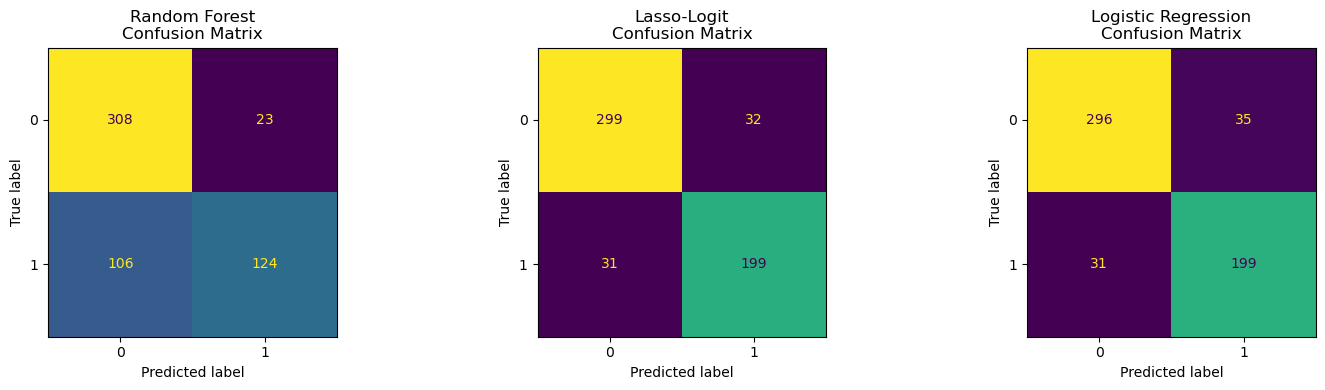

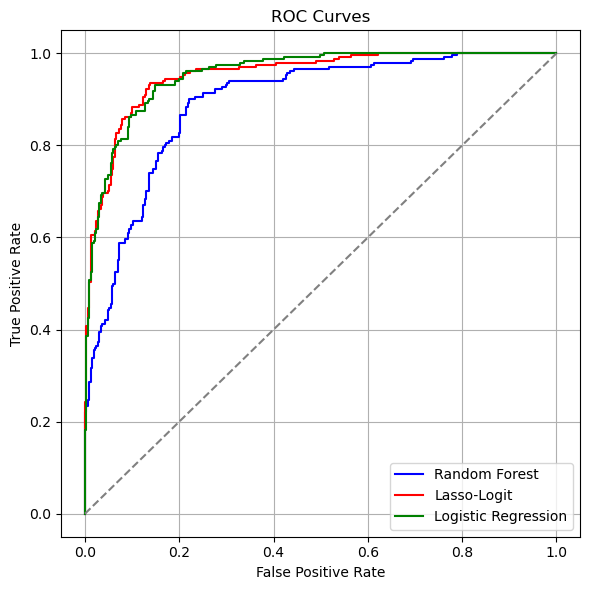

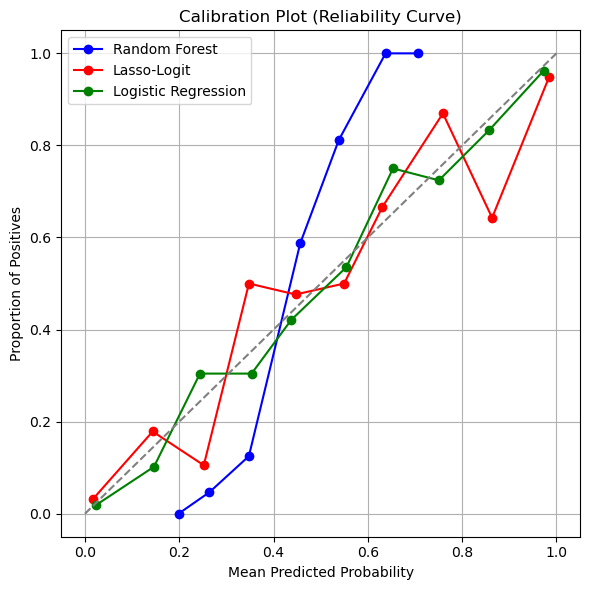

In [19]:
# Load predictions

y_true = results_preds_df["y_true"]
model_outputs = {
    "Random Forest": {
        "y_pred": results_preds_df["y_pred_rf"],
        "y_proba": results_preds_df["y_proba_rf"],
        "color": "blue"
    },
    "Lasso-Logit": {
        "y_pred": results_preds_df["y_pred_lasso"],
        "y_proba": results_preds_df["y_proba_lasso"],
        "color": "red"
    },
    "Logistic Regression": {
        "y_pred": results_preds_df["y_pred_log"],
        "y_proba": results_preds_df["y_proba_log"],
        "color": "green"
    }
}

# Print Raw classification metrics
def print_classification_metrics(y_true, y_pred, y_proba, model_name):
    print(f"\n Metrics for {model_name}")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred), 4))
    print("Recall:", round(recall_score(y_true, y_pred), 4))
    print("F1 Score:", round(f1_score(y_true, y_pred), 4))
    print("ROC AUC:", round(roc_auc_score(y_true, y_proba), 4))
    print("Avg Precision (PR AUC):", round(average_precision_score(y_true, y_proba), 4))

for model_name, output in model_outputs.items():
    print_classification_metrics(y_true, output["y_pred"], output["y_proba"], model_name)

# Plot Confusion Matrices Side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (model_name, output) in zip(axes, model_outputs.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_true, output["y_pred"], ax=ax, colorbar=False
    )
    ax.set_title(f"{model_name}\nConfusion Matrix")
plt.tight_layout()
plt.show()

# Plot ROC Curve for All Models (same plot) 
plt.figure(figsize=(6, 6))
for model_name, output in model_outputs.items():
    fpr, tpr, _ = roc_curve(y_true, output["y_proba"])
    plt.plot(fpr, tpr, label=model_name, color=output["color"])
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Calibration Curves (same plot; 3 models)
plt.figure(figsize=(6, 6))
for model_name, output in model_outputs.items():
    prob_true, prob_pred = calibration_curve(y_true, output["y_proba"], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=model_name, color=output["color"])
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Proportion of Positives")
plt.title("Calibration Plot (Reliability Curve)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


** Feature Importance **
Next, we investigate feature importance.

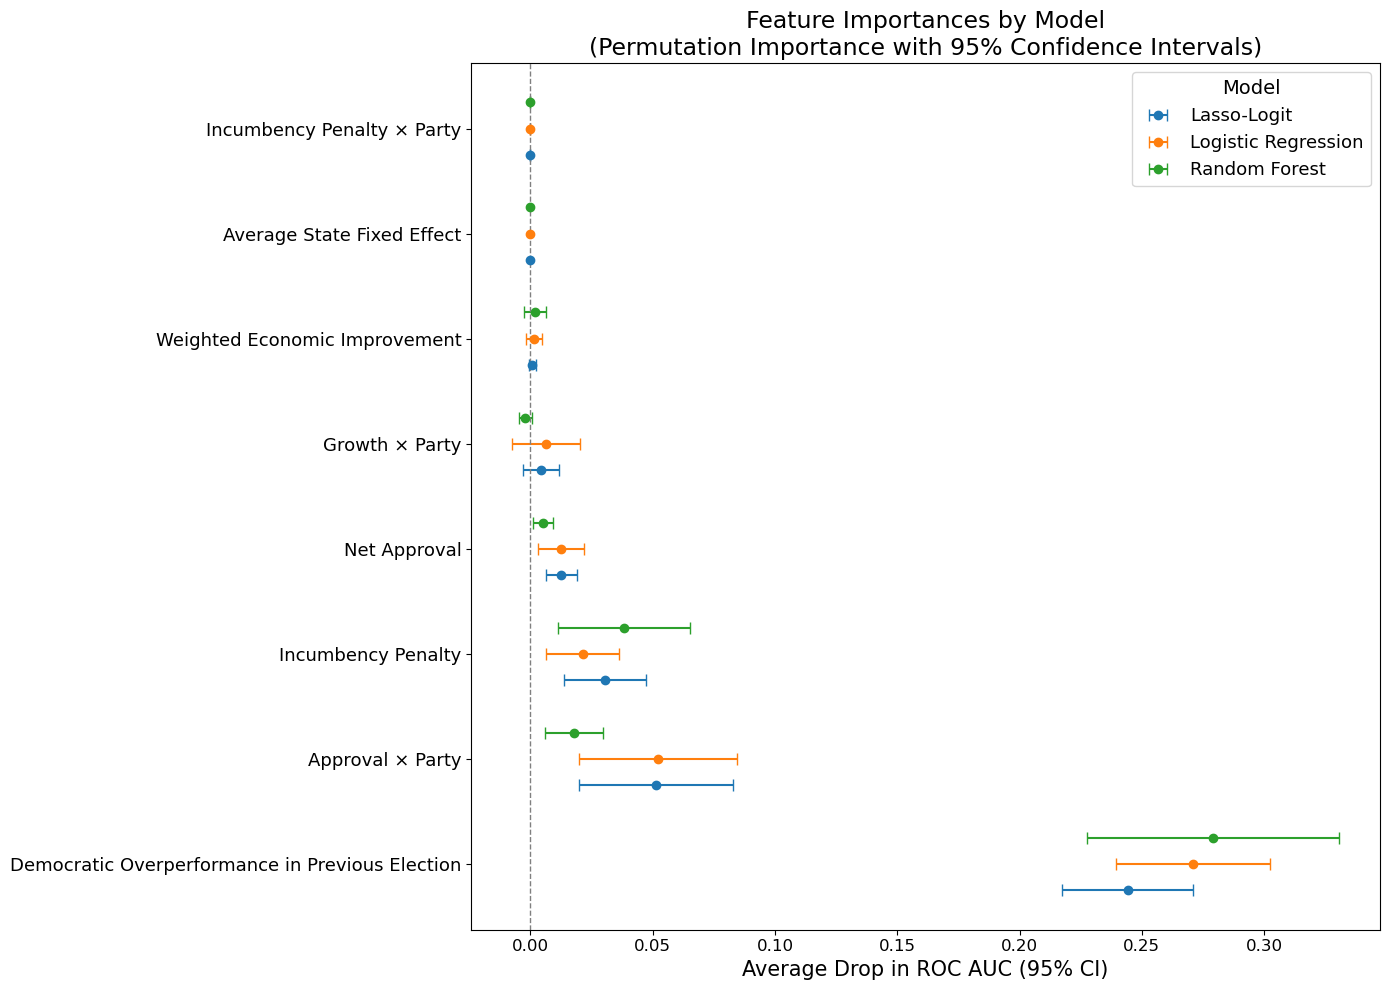

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collapse state fixed effects into one feature
def collapse_state_effects(df):
    df = df.copy()
    is_state = df["Feature"].str.contains("cat__State_")
    
    # Group state fixed effects by model and average them
    grouped = df[is_state].groupby(["Model"])[["Importance", "Std"]].mean().reset_index()
    grouped["Feature"] = "Average State Fixed Effect"
    
    # Drop individual state effects and append the grouped row
    df_clean = df[~is_state]
    collapsed_df = pd.concat([df_clean, grouped], ignore_index=True)
    return collapsed_df

# Pretty labels for features: the preprocessor above has changed the names slightly.
pretty_labels = {
    "num__weighted_growth": "Weighted Economic Improvement",
    "num__net_approval": "Net Approval",
    "num__weighted_growth_x_party": "Growth × Party",
    "num__net_approval_x_party": "Approval × Party",
    "num__State_Deviation_4yr": "Democratic Overperformance in Previous Election",
    "num__incumbency_penalty": "Incumbency Penalty",
    "num__incumbency_penalty_x_party": "Incumbency Penalty × Party",
    "Average State Fixed Effect": "Average State Fixed Effect"
}

# Apply feature collapsing and label mapping
collapsed_df = collapse_state_effects(perm_importance_df)

# Add readable feature names
collapsed_df["Pretty Feature"] = collapsed_df["Feature"].apply(
    lambda x: pretty_labels.get(x, x)
)

# Count number of CV folds
n_folds = collapsed_df["Year"].nunique()

# Compute average importance and 95% CI using SD from the permutations
summary_df = (
    collapsed_df
    .groupby(["Model", "Pretty Feature"])
    .agg(
        Mean=("Importance", "mean"),
        Std=("Importance", "std")
    )
    .reset_index()
)

# 95% confidence interval
summary_df["CI"] = 1.96 * summary_df["Std"] / np.sqrt(n_folds)

# Sort features by average importance (across all models)
feature_order = (
    summary_df.groupby("Pretty Feature")["Mean"]
    .mean()
    .sort_values(ascending=False)
    .index
)

summary_df["Pretty Feature"] = pd.Categorical(
    summary_df["Pretty Feature"],
    categories=feature_order,
    ordered=True
)

summary_df = summary_df.sort_values(["Pretty Feature", "Model"])

# Rename models for consistent display
model_names = {
    "Random Forest": "Random Forest",
    "LASSO": "Lasso-Logit",
    "Logistic Regression": "Logistic Regression"
}
summary_df["Model"] = summary_df["Model"].map(model_names)

# Plot feature importances
fig, ax = plt.subplots(figsize=(14, 10))

models = summary_df["Model"].unique()
y_positions = np.arange(len(feature_order))
offset = 0.25  # space between model dots for each feature

for i, model in enumerate(models):
    data = summary_df[summary_df["Model"] == model]
    ax.errorbar(
        data["Mean"],
        y_positions + (i - 1) * offset,
        xerr=data["CI"],
        fmt='o',
        capsize=4,
        label=model
    )

# Add formatting
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_yticks(y_positions)
ax.set_yticklabels(feature_order, fontsize=13)
ax.set_xlabel("Average Drop in ROC AUC (95% CI)", fontsize=15)
ax.set_title("Feature Importances by Model\n(Permutation Importance with 95% Confidence Intervals)", fontsize=17)
ax.legend(title="Model", fontsize=13, title_fontsize=14)
ax.tick_params(axis='x', labelsize=12)
plt.tight_layout()
plt.show()


**Evaluating Model Performance on Electoral College**

Electoral College Scores were not included in MIT Database, but were scraped from University of California Santa Barbara's The American Presidency Project (https://www.presidency.ucsb.edu/statistics/elections)
I did this using R, so haven't included the code here.

In [21]:
# Drop duplicate/conflicting columns before merging
electoral_votes = pd.read_csv("state_electoral_votes_1980_2020.csv")

columns_to_drop = [col for col in electoral_votes.columns if col in results_preds_df.columns and col not in ["Year", "State"]]
electoral_votes_clean = electoral_votes.drop(columns=columns_to_drop)

# Merge electoral votes into prediction results
results_preds_df = results_preds_df.merge(
    electoral_votes_clean,
    how="left",
    left_on=["Year", "State_Name"],
    right_on=["Year", "State"]
)

#  Drop redundant 'State' column
results_preds_df = results_preds_df.drop(columns=["State"])

# Calculate Expected Electoral Votes
model_pred_cols = [col for col in results_preds_df.columns if col.startswith("y_proba_")]

expected_ec_list = []
for model_col in model_pred_cols:
    temp = results_preds_df.copy()
    temp["Expected_EC"] = temp[model_col] * temp["ElectoralVotes"]
    temp["Model"] = model_col.replace("y_proba_", "")  # e.g., 'rf', 'lasso', 'log'
    grouped = temp.groupby(["Year", "Model"])["Expected_EC"].sum().reset_index()
    expected_ec_list.append(grouped)

expected_ec_df = pd.concat(expected_ec_list, ignore_index=True)

# Calculate actual Electoral College outcome
actual_ec_df = (
    results_preds_df[results_preds_df["y_true"] == 1]
    .groupby("Year")["ElectoralVotes"]
    .sum()
    .reset_index(name="Actual_EC")
)

# Calculate EC win threshold
threshold_df = (
    results_preds_df.groupby("Year")["ElectoralVotes"]
    .sum()
    .reset_index()
)
threshold_df["Win_Threshold"] = threshold_df["ElectoralVotes"] / 2

# Merge all into one plot-ready DataFrame
plot_df = expected_ec_df.merge(actual_ec_df, on="Year", how="left")
plot_df = plot_df.merge(threshold_df[["Year", "Win_Threshold"]], on="Year", how="left")

# Choose which models to include in the summary
plot_models = ['rf', 'lasso', 'log']  
filtered_df = plot_df[plot_df["Model"].isin(plot_models)]

# Pivot table to compare models side by side
pivot_df = filtered_df.pivot(index="Year", columns="Model", values="Expected_EC").reset_index()

# Merge actual results and win threshold
pivot_df = pivot_df.merge(actual_ec_df, on="Year", how="left")
pivot_df = pivot_df.merge(threshold_df[["Year", "Win_Threshold"]], on="Year", how="left")

# Sort so the most recent election is first
pivot_df = pivot_df.sort_values("Year", ascending=False)

# Add actual and predicted winners
pivot_df["Actual_Winner"] = (pivot_df["Actual_EC"] >= pivot_df["Win_Threshold"]).map({True: "Dem", False: "GOP"})

# Add predicted winners for each model
for model in plot_models:
    pred_col = f"Predicted_Winner_{model}"
    pivot_df[pred_col] = (pivot_df[model] >= pivot_df["Win_Threshold"]).map({True: "Dem", False: "GOP"})

# Display
cols_to_show = ["Year", "Actual_EC", "Win_Threshold", "Actual_Winner"] + \
               plot_models + \
               [f"Predicted_Winner_{model}" for model in plot_models]

print(pivot_df[cols_to_show].head(1000))


    Year  Actual_EC  Win_Threshold Actual_Winner          rf       lasso  \
10  2020      301.0          265.0           Dem  260.369597  394.740663   
9   2016      229.0          265.5           GOP  203.145385  220.239161   
8   2012      329.0          267.5           Dem  229.364786  302.112908   
7   2008      361.0          265.5           Dem  246.585646  301.171233   
6   2004      248.0          267.0           GOP  210.482735  269.146832   
5   2000      264.0          267.5           GOP  206.996170  218.665647   
4   1996      376.0          267.5           Dem  217.981979  391.898726   
3   1992      367.0          267.5           Dem  252.743157  317.145671   
2   1988      108.0          267.0           GOP  178.885718   81.282463   
1   1984       10.0          267.5           GOP  216.399810  109.192265   
0   1980       87.0          267.5           GOP  253.547622   94.611504   

           log Predicted_Winner_rf Predicted_Winner_lasso Predicted_Winner_log  
10  40

In [28]:
import zipfile

# List of files to include in the zip
files_to_zip = [
    "State_Level_Economy.csv",
    "31120311.csv",
    "1976-2020-president.csv",
    "state_electoral_votes_1980_2020.csv",
    "Election_Forecasting.ipynb"
]

# Name of the output zip file
output_zip = "QSLH7.zip"

# Create the zip file with compression
with zipfile.ZipFile(output_zip, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        zipf.write(file)

print(f"{output_zip} created successfully!")

QSLH7.zip created successfully!
